# Tree Search Demo

In [2]:
# your other imports here ...
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

# TODO: replace with your path/to/ninarow
ninarowdir = os.path.dirname(os.getcwd())
modelfitdir = ninarowdir + "/model_fitting/"
# os.listdir(modelfitdir)

# sets the import path to the model-fitting directory
sys.path.insert(0, modelfitdir)
from parsers import *
from model_fit import *
from utils import *
import model_fit
from tqdm import tqdm

# WARNING: %load_ext autoreload and %autoreload 2 may interfere with 
# the Multi-threading processes!
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Handling

### File Formatting
The data columns should be ordered: 

    - black_pieces (binary), 
    - white_pieces (binary), 
    - player_color (Black/White), 
    - move (binary), 
    - response time (not used in fitting), 
    - [group_id] (optional), 
    - participant_id

for more info, see `parsers.py`

In [14]:
# TODO: make a folder (here I've called it "data/")
# which holds your data in a csv called data.csv and put its directory here ...
data_path = "../data"
data_csv = f"{data_path}/data.csv"
df = pd.read_csv(data_csv)[:30]
df.head()

,black,white,color,move,response_time,participant_id
0,16,0,White,4194304,1,1
1,16400,4194304,White,8388608,1,1
2,16793616,12582912,White,2097152,1,1
3,8192,0,White,4194304,1,1
4,2105344,4194304,White,16,1,1


We can show the boards using the `show` function from `utils`.

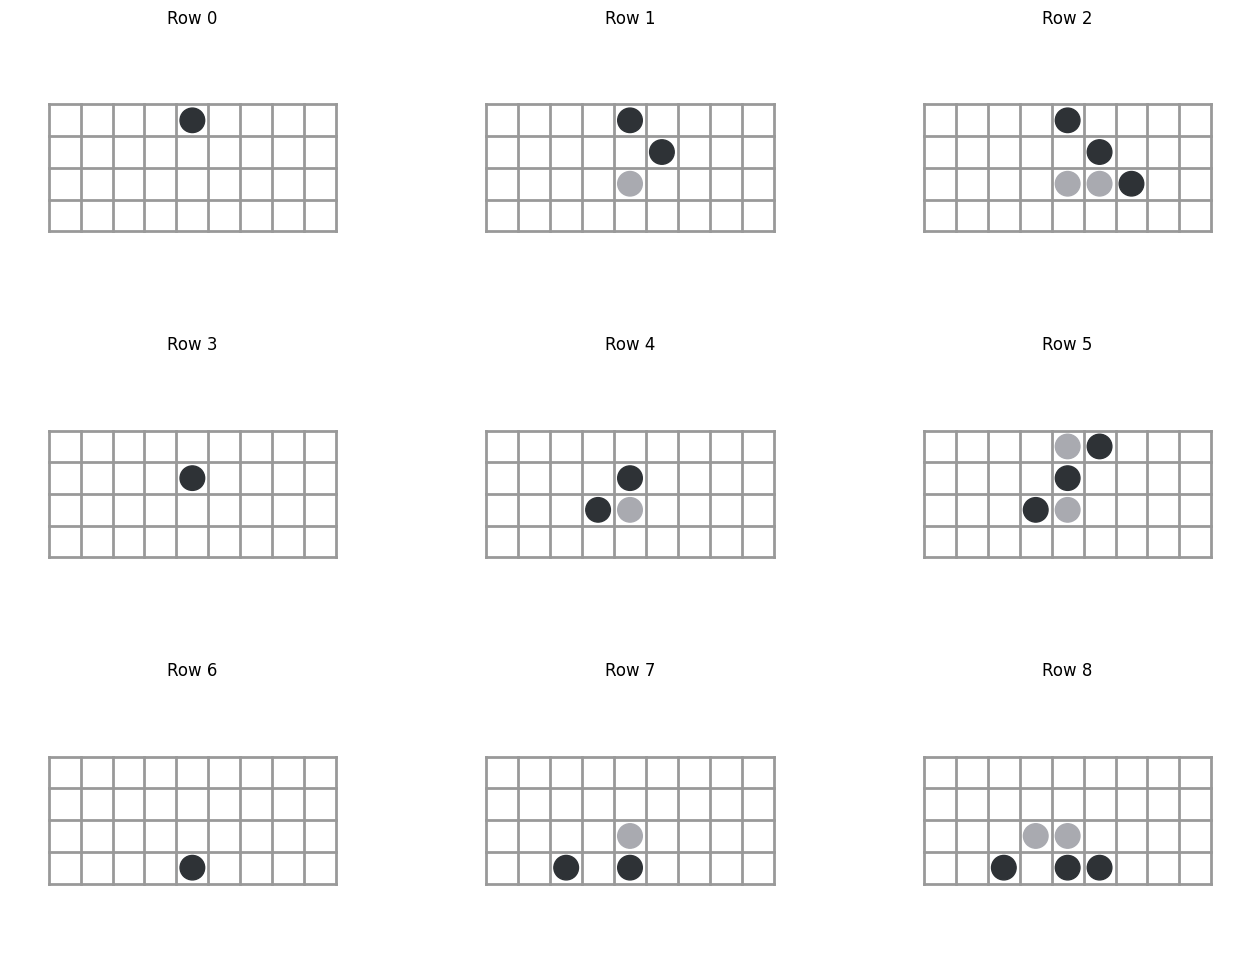

In [15]:
from utils import show

fig = plt.figure(figsize = (16, 12))
for i, row in enumerate(df.head(9).itertuples()): 
    ax = plt.subplot(3, 3, i + 1)
    show(row.black, row.white, existing_fig=(fig, ax))
    ax.set_title(f"Row {i}")

## Creating Cross Validation Splits

We can easily create cross validation splits by using `utils.make_splits`, which takes in a dataframe
and outputs into a specified `data_path`

In [16]:
from utils import make_splits
import random
import numpy as np

random.seed(10)
np.random.seed(10)

splits = make_splits(df, output_dir = data_path)
# view the first few lines of the first split
splits[0].head()

Saving split1 to ../data/1.csv
Saving split2 to ../data/2.csv
Saving split3 to ../data/3.csv
Saving split4 to ../data/4.csv
Saving split5 to ../data/5.csv


,black,white,color,move,response_time,participant_id
0,17179873280,4194304,White,2097152,1,1
1,17180921856,6291456,White,8388608,1,1
2,4096,0,White,4194304,1,1
3,17197699080,14688256,White,16,1,1
4,4294967296,0,White,4194304,1,1


The parser takes in a CSV filename and turns it into a list of 
objects of type CSVMove ...

# Fitting the Model to Data

In [4]:
data_path = "../data"
output_path = "../data/out"
n_splits = 5
fold_number = 1
threads = 1
random_sample = False
verbose = True

print(f"Building output directory at {output_path}")
os.makedirs(output_path, exist_ok = True)

Building output directory at ../data/out


## Part 1: Loading Data

In [18]:
# first, we have to check to see if all the splits are there ...
assert np.all([f"{i + 1}.csv" in os.listdir(data_path) for i in range(n_splits)])
print("Detected splits in this directory. Loading splits ...")

# then we read them in
splits = [pd.read_csv(f"{data_path}/{i + 1}.csv") for i in range(n_splits)]

# we convert every row of our CSV to a "CSVMove object" using df_to_CSVMove - we do so for all the splits
# CSVMove is a class that is defined in the parsers.py file 
fold_data = [[csvmove for csvmove in df_to_CSVMove(split, warn = False)] for split in splits]

Detected splits in this directory. Loading splits ...


## Part 2: Model Fitting

To ensure that the code is perfectly reproducible, we use a **single thread** and we set the manual seed to a number of our choosing. If we use multiple threads, the code will still work but the operating system may choose the order of the threads arbitrarily, leading to variation in the output.

You should see an output that looks something like: 

    Setting manual seed 10 for single-thread
    Thread 0: Base Seed 10, Seed: 10, Random Number: 601088376405717203

Note that if you run this code multiple times, the Random Number should be the same. This means our thread will be initialized with a particular random seed - as it runs, it will not be reinitialized, so the randomness will still proceed, but in a predictable way.

In [19]:
from multiprocessing import Pool, Value, set_start_method


We are now ready to begin running our model. We will begin with the default model and then feed it to our  `ModelFitter` class. Note that this code may take a very long time to run (a couple hours)...

If you are using multiple threads and seeing a thread-related error, please make sure to turn OFF `%load_ext autoreload` and `%autoreload 2` from the import statements above

In [ ]:
random.seed(10)
initialize_thread_pool(1, manual_seed = 10)

model_fitter = ModelFitter(DefaultModel(), 
                           random_sample = random_sample, 
                           verbose = verbose, 
                           threads = threads)

params, loglik_train, loglik_test = model_fitter.cross_validate(fold_data, fold_number - 1)

In [32]:
from model_fit import *
random.seed(10)
initialize_thread_pool(1, manual_seed = 10)

model_fitter = ModelFitter(DefaultModel(), 
                           random_sample = random_sample, 
                           verbose = verbose, 
                           threads = threads)

model_fitter.fit_model(fold_data[fold_number - 1])

Setting manual seed 10 for single-thread
Thread 0: Base Seed 10, Seed: 10, Random Number: 601088376405717203

[Preprocessing] Initial log-likelihood estimation


100%|██████████| 6/6 [00:00<00:00, 14217.98it/s]


[0] NLL: 9.2936 Params: [2.001, 0.02, 0.2, 0.05, 1.2, 0.801, 1.001, 0.4, 3.501, 5.0]
Beginning optimization of a STOCHASTIC objective function

 Iteration    f-count      E[f(x)]        SD[f(x)]           MeshScale          Method              Actions
     0           1         9.29357             nan               1                                  
[1] NLL: 20.3258 Params: [1.053, 0.68, 0.147, 0.292, 0.539, 0.952, -1.899, -1.372, -4.072, -3.799]


KeyboardInterrupt: 

We can examine the fitted model parameters below ...

In [ ]:
loglik_train_df = pd.DataFrame(loglik_train, columns = ["loglik_train"])
loglik_test_df = pd.DataFrame(loglik_test, columns = ["loglik_test"])

print("Fitted Model Parameters")
param_df = pd.DataFrame(dict(zip(model_fitter.model.param_names, params), index = [0])).drop("index", axis = 1)
param_df

## Part 3: Saving Parameters

We will save the log likelihood for the train and test folds, as well as the parameters, as `{fold_number}_lltrain.csv`, `{fold_number}_lltest.csv`, and `{fold_number}_params.csv` in the directory specified by `{output_path}`

In [ ]:
loglik_train_df.to_csv(f"{output_path}/{fold_number}_lltrain.csv", index = False)
loglik_test_df.to_csv(f"{output_path}/{fold_number}_lltest.csv", index = False)
param_df.to_csv(f"{output_path}/{fold_number}_params.csv", index = False)

# Running an Existing Model

## Loading the Model Parameters

First, let's load our model parameters in from a csv file ...

In [5]:
param_path = f"{output_path}/{fold_number}_params.csv"
param_df = pd.read_csv(param_path)
params = param_df.iloc[0].values

# set the parameters of the model that will be used in the tree search
model = DefaultModel()
heuristic = model.create_heuristic(params)

## Predicting moves on an example board

Let's start by taking an arbitrary board state and run our model prediction on it ...

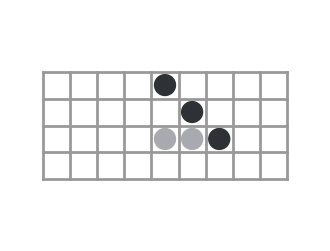

In [6]:
black = 16793616	
white = 12582912
show(black, white)

# create a fourbynineboard object out of our patterns ...
board = fourbynine_board(fourbynine_pattern(black), fourbynine_pattern(white))

In [7]:
search = model.create_search(params, heuristic, board)
search.complete_search()
best_move_index = heuristic.get_best_move(search.get_tree()).board_position

Predicted Move shown in BLUE


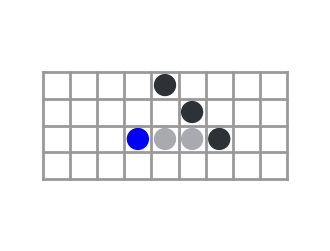

In [8]:
fig = plt.figure(figsize = (4, 3))
ax = plt.subplot(1, 1, 1)

show(black, white, existing_fig=(fig, ax))
add_circle(best_move_index, existing_fig=(fig, ax), color = "blue")
print("Predicted Move shown in BLUE")


## Make a Heatmap of Predictions from Multiple Searches
You might notice that there is noisiness in the behavior of the model. To show how the model behaves over several runs, we'll want to show a heatmap of the different predictions

100%|██████████| 100/100 [00:00<00:00, 106.67it/s]


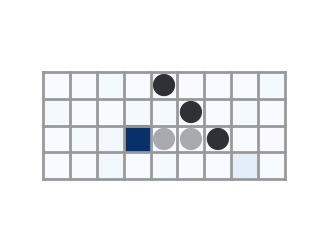

In [9]:
n_samples = 100
counts = np.zeros(36)
for _ in tqdm(range(n_samples), leave=True): 
    search = model.create_search(params, heuristic, board)
    search.complete_search()
    best_move_index = heuristic.get_best_move(search.get_tree()).board_position
    counts[best_move_index] += 1

fig = plt.figure(figsize = (4, 3))
ax = plt.subplot(1, 1, 1)
show(black, white, existing_fig=(fig, ax))

# the [::-1] is to flip the board because of a quirk in the way the board is plotted
# you basically have to mirror it over the y-axis (see "extent" below)
ax.imshow(counts.reshape(4, 9)[::-1], cmap = "Blues", extent=[85, 715, -160, -440], alpha = 1)